<a href="https://colab.research.google.com/github/anantoj/pytorch-mini-projects/blob/main/basic_neural_network_fashionmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = FashionMNIST(root='/content', download=True, transform=ToTensor())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Split the data in training and validation sets

In [3]:
VAL_SIZE = 10000
TRAIN_SIZE = len(dataset) - VAL_SIZE

train_data, val_data = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])
len(train_data), len(val_data)

(50000, 10000)

In [4]:
BATCH_SIZE = 128

Create the data loaders

In [5]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])


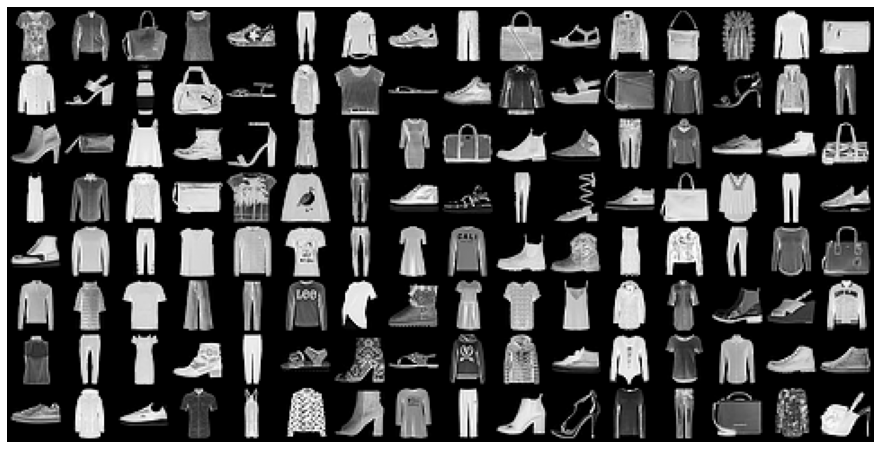

In [6]:
for images, _ in train_loader:
    print(images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

# Constructing the Neural Network

First we will need to create input tensors by flattening the image

In [7]:
for images, labels in train_loader:
    print(images.shape)
    inputs = images.reshape(-1, 28*28)
    print(inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


Next, we can create our hidden linear layer and set the outputs size of the layer to be 32.

In [8]:
input_size = inputs.shape[-1]
hidden_size = 32

layer1 = nn.Linear(input_size, hidden_size)

We can compute the outputs for the first image batch by passing `inputs` to `layer1`

In [9]:
layer1_out = layer1(inputs)
print(layer1_out.shape)

torch.Size([128, 32])


What essentially happened is similar to the linear regression model that we created. Because of this, our current neural network can only capture linear relationships.

We can add an additional activation function called the Rectified Linear Unit or ReLU. It replaces negative values in the tensor to the value 0. Obviously, ReLU is a non-linear function.

We can use `F.relu` to apply the ReLU function to a tensor

In [10]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

We can apply this activation function to `layer1_out`

In [11]:
relu_out = F.relu(layer1_out)
print(torch.min(layer1_out).item())
print(torch.min(relu_out).item())

-0.8355385065078735
0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [12]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

layer2_out = layer2(relu_out)
print(layer2_out.shape)

torch.Size([128, 10])


We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [13]:
loss = F.cross_entropy(layer2_out, labels)
loss

tensor(2.3294, grad_fn=<NllLossBackward>)

# Neural Network Model

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.

Let's define the model by extending the `nn.Module` class from PyTorch.

In [14]:
from torch.optim import SGD
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images) # predict
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc' : acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine losses
        batch_accs = [x['val_acc'] for x in outputs] 
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
        return {'val_loss':epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

    def evaluate(self, val_loader):
        outputs = outputs = [self.validation_step(batch) for batch in val_loader]
        result = self.validation_epoch_end(outputs)
        return result

    def fit(self, epochs, learning_rate, train_loader, val_loader, opt=SGD):
        optimizer = opt(self.parameters(), learning_rate)
        history = [] 

        for epoch in range(epochs):

            for batch in train_loader:
                loss = self.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad() 
                
            result = self.evaluate(val_loader)
            self.epoch_end(epoch, result)
            history.append(result)
        
        return history


In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds==labels).item()
    return torch.tensor(correct / len(preds))

In [16]:
model = MnistModel()

In [17]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [18]:
for images, labels, in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss: ', loss.item())
    break

print(outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss:  2.32302188873291
tensor([[ 0.0869,  0.1362,  0.1042, -0.0894,  0.1272,  0.1113, -0.1128,  0.1267,
          0.1915,  0.1608],
        [ 0.1545,  0.2594,  0.1344, -0.0862, -0.0065,  0.1830, -0.1335,  0.0727,
          0.2822,  0.1100]])


# Using a GPU

We can check if a GPU is available and the required NVIDIA CUDA drivers are isntalled using the follow code

In [19]:
torch.cuda.is_available()

False

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [20]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [21]:
device = get_default_device()

Next, let's define a function that can move data and model to a chosen device.

In [22]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [23]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch data loader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [24]:
class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device) 
    
    def __len__(self):
        return len(self.dataloader)

In [25]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [26]:
for x, y, in val_loader:
    print(x.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


cpu


# Training the Model

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [27]:
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [28]:
history = [model.evaluate(val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.08857421576976776, 'val_loss': 2.304809808731079}]

Let's train the model for five epochs with a high learning rate and look at the results.

In [29]:
history = model.fit(epochs=8, learning_rate=0.3, train_loader=train_loader, val_loader=val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1, val_loss: 0.4755, val_acc: 0.8298
Epoch 2, val_loss: 0.4885, val_acc: 0.8235
Epoch 3, val_loss: 0.4329, val_acc: 0.8415
Epoch 4, val_loss: 0.4031, val_acc: 0.8569
Epoch 5, val_loss: 0.4406, val_acc: 0.8420
Epoch 6, val_loss: 0.4099, val_acc: 0.8545
Epoch 7, val_loss: 0.3927, val_acc: 0.8577
Epoch 8, val_loss: 0.4060, val_acc: 0.8589


Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [30]:
history += model.fit(epochs=5, learning_rate=0.1, train_loader=train_loader, val_loader=val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1, val_loss: 0.3550, val_acc: 0.8734
Epoch 2, val_loss: 0.3537, val_acc: 0.8769
Epoch 3, val_loss: 0.3529, val_acc: 0.8762
Epoch 4, val_loss: 0.3526, val_acc: 0.8771
Epoch 5, val_loss: 0.3566, val_acc: 0.8754


Text(0, 0.5, 'loss')

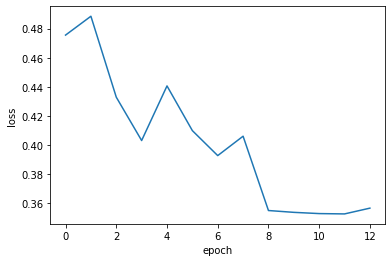

In [31]:
losses = [x['val_loss'] for x in history]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'acc')

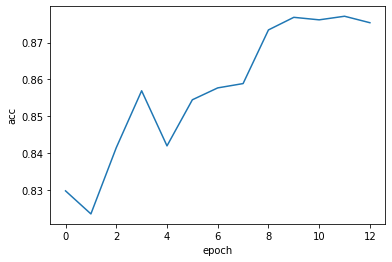

In [32]:
accs = [x['val_acc'] for x in history]
plt.plot(accs)
plt.xlabel('epoch')
plt.ylabel('acc')

# Performance on Test Set

In [33]:
test_dataset = FashionMNIST(root='/content', train=False, transform=ToTensor())

In [34]:
def predict_image(img, model):
    print(img.shape)
    x = to_device(img, device)
    y = model(x)
    _, preds = torch.max(y, dim=1)
    return preds[0].item()

torch.Size([1, 28, 28])
Label: 9 , Predicted: 9


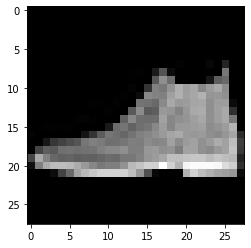

In [35]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [36]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, 32), device)
result = model.evaluate(test_loader)
result

{'val_acc': 0.868510365486145, 'val_loss': 0.3743351399898529}